In [44]:
import pandas as pd
import numpy as np

#time
from datetime import datetime
import calendar
import time

#plots
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

import plotly.io as pio
pio.renderers.default="notebook"

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns


#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

#torch
import torch

#time series analysis
import statsmodels.tsa.stattools as sts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ModuleNotFoundError: No module named 'plotly'

<a name='part2'></a>
# 2. Data cleaning and preprocessing



In [41]:
def add_calendar_features(df):
    df_new = df.copy()
    df_new['ts'] = pd.Timestamp('2019-01-01')+pd.to_timedelta(df_new.index, unit='H')
    df_new.set_index(['ts'], inplace=True)
    df_new["Month"] = pd.DatetimeIndex(df.index).month
    df_new["Hour"] = pd.DatetimeIndex(df.index).hour
    df_new["Day of Week"] = pd.DatetimeIndex(df.index).dayofweek
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Day of Week"], "dow")], axis=1)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Hour"], "hod")], axis=1)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Month"], "month")], axis=1)

    return df_new



In [42]:
df_dw = pd.read_csv("data/balance_dw.csv")
df_up = pd.read_csv("data/balance_up.csv")
df_dw.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)
df_up.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)
df_up = add_calendar_features(df_up)
df_dw = add_calendar_features(df_dw)


In [43]:


def plot_time_data(df):
    df_month = df.groupby(["Month"]).mean().reset_index()
    df_dow = df.groupby(["Day of Week"]).mean().reset_index()
    df_hod = df.groupby(["Hour"]).mean().reset_index()


    fig = make_subplots(rows=1, cols=3, subplot_titles=["Hour of Day", "Day of Week", "Month"])

    fig.update_layout(
        barmode='group',
        title_text="Average electricity price grouped by hour of day, day of week and month"
    )

    months = [calendar.month_abbr[i] for i in range(1,13)]
    dows = [calendar.day_abbr[i] for i in range(0,7)]
    hods = ["0"+str(i)+":00" if i < 10 else str(i)+":00" for i in range(0,24)]

    fig.append_trace(go.Bar(x=months, y=df_month["SpotPriceDKK"], marker_color="blue", showlegend=False), row=1, col=3)
    fig.append_trace(go.Bar(x=dows, y=df_dow["SpotPriceDKK"], marker_color="blue", showlegend=False), row=1, col=2)
    fig.append_trace(go.Bar(x=hods, y=df_hod["SpotPriceDKK"], marker_color="blue", showlegend=False), row=1, col=1)

    fig.update_yaxes(title_text="Average electricity price DKK/MWh", row=1, col=1)

    fig.show()

Looking at the first plot, it is clear that there is a daily pattern. There is a morning peak, an evening peak and less demand during the night. This is in alignment with what is expected. When people rise in the morning they usually cook breakfast (peak) then go to work (less demand) and finally return home to cook dinner and relax (peak).

When looking at the day of week, it clearly shows that the weekend has a lower average price, which is consistent with the expectation as well.

Finally, the average price for the months shows no clearly identifiable pattern. 

To conclude, there are definitly patterns in the spot price, which should be accounted for in the model somehow!

In [ ]:
df_test=df.reset_index()
df_test["Weekday"]=df_test.hour.apply(lambda x: datetime.strftime(x, '%A'))
df_weekday=df_test.groupby(["Hour","Weekday"]).mean().unstack(0)
fig = go.Figure()

fig.add_trace(go.Scatter(name="Monday",x=hods, y=df_weekday[df_weekday.index=="Monday"]["SpotPriceDKK"].T.Monday, marker_color="blue", showlegend=True))
fig.add_trace(go.Scatter(name="Tuesday",x=hods, y=df_weekday[df_weekday.index=="Tuesday"]["SpotPriceDKK"].T.Tuesday, marker_color="red", showlegend=True))
fig.add_trace(go.Scatter(name="Wednesday",x=hods, y=df_weekday[df_weekday.index=="Wednesday"]["SpotPriceDKK"].T.Wednesday, marker_color="green", showlegend=True))
fig.add_trace(go.Scatter(name="Thursday",x=hods, y=df_weekday[df_weekday.index=="Thursday"]["SpotPriceDKK"].T.Thursday, marker_color="purple", showlegend=True))
fig.add_trace(go.Scatter(name="Friday",x=hods, y=df_weekday[df_weekday.index=="Friday"]["SpotPriceDKK"].T.Friday, marker_color="cyan", showlegend=True))
fig.add_trace(go.Scatter(name="Saturday",x=hods, y=df_weekday[df_weekday.index=="Saturday"]["SpotPriceDKK"].T.Saturday, marker_color="#f542ce", showlegend=True))
fig.add_trace(go.Scatter(name="Sunday",x=hods, y=df_weekday[df_weekday.index=="Sunday"]["SpotPriceDKK"].T.Sunday, marker_color="#f59042", showlegend=True))



fig.show()

From the plot above it can be seen how the elspotprices peak in the morning where people get ready for work and in the evening when people return from. Furthermore, the weekend has the same tendency but the now the peak hours are postponed one hour. This might be caused by it is actually weekend. Anyhow, the elspotprices are much lower during the weekends, this could be due to  lower demand of power as some industries are closed during the weekend.

<a name="part3"></a>
# 3. Initial modelling

To ensure a correct generalization error of our models we need to split our data into a train and test set. As the data is a time series, we should not shuffle our data, as it can not be deemed fair to have a model that has learnt from the future. Therefore, we opt for the train set to be the first 9 months of 2019 and the test to be last 3 months. As explained earlier, there is no point in including the dummy variables for the month. Before splitting the data, we standardize both the non-dummy attributes and the target variable.

We also displace the non-dummy attributes backwards in time, since in reality when we want to predict the price at hour $h$, we won't have access to the weather data at hour $h$, since $h$ is in the future at that time! To account for this, we move all non-dummy attributes backwards 1 time-step. 

In [ ]:
#define features
non_dummy_features = ['wspd', 'wpgt', 'temp', 'dwpt']
features = non_dummy_features \
    + [f"dow_{i}" for i in range(7)] \
    + [f"hod_{i}" for i in range(24)]

#create X and y
X = df[features]
y = df[['SpotPriceDKK']]

# displace X and y
X_displaced = X.iloc[:-1,:]
for attr in features:
  if attr in non_dummy_features:
    X_displaced[attr] = X[attr][1:].to_numpy()
  else:
    X_displaced[attr] = X[attr][:-1].to_numpy()

y_displaced = y[:-1]

X = X_displaced
y = y_displaced

X_means = [X[attr][:"2019-10-01"].mean() for attr in non_dummy_features]
X_stds = [X[attr][:"2019-10-01"].std() for attr in non_dummy_features]
y_mean = y[:"2019-10-01"].mean()[0]
y_std = y[:"2019-10-01"].std()[0]

# standardize X and y based on train set
for i, attr in enumerate(non_dummy_features):
  X[attr] = (X[attr] - X_means[i]) / X_stds[i]

y = (y - y_mean) / y_std

# Final train and test sets
X_train = X[:"2019-10-01"].to_numpy()
y_train = y[:"2019-10-01"].to_numpy()
X_test = X["2019-10-01":].to_numpy()
y_test = y["2019-10-01":].to_numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We define a quick little function to print some evaluation scores:

In [ ]:
from sklearn.metrics import r2_score

def get_score(y_test, y_hat):
  corr, mae, rae, rmse, _ = compute_error(y_test, y_hat)
  r2 = r2_score(y_test, y_hat)
  print("CorrCoeff: ", corr)
  print("MAE: ", rae)
  print("RMSE: ", rmse)
  print("R2: ", r2)

#define function that calculates performance of model
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

<a name="part3.1"></a>
## 3.1 Baseline model using sklearn

To get a baseline to compare the later pyro models to, a standard linear regression model from sklearn is fitted using the data:

In [ ]:
# Test with sklearns LinearRegression algorithm
mdl_LR = LinearRegression()
mdl_LR.fit(X_train, y_train.flatten())
y_hat = mdl_LR.predict(X_test)

# Return to unnormalized
y_hat = (y_hat * y_std) + y_mean
y_true = (y_test * y_std) + y_mean

get_score(y_true.flatten(), y_hat)

CorrCoeff:  0.7139408242111367
MAE:  0.8969941410731389
RMSE:  68.12319252824922
R2:  0.36049647415185504


The R2 score is fairly promising already. Hopefully we can beat it!

<a name="part3.2"></a>
## 3.2 Bayesian Regression

The first pyro implementation will be an SVI model with simple Bayesian regression with the following generative process:

1.  Draw coefficients
    * $\alpha - N(\alpha | 0, 1)$
    * $\beta - N(\beta | \textbf{0}, \textbf{1})$
    * $\sigma - HalfCauchy(\sigma | 5)$
3.  For each time, $t$.
      * Draw observation $y_t - N(y_t|\alpha + \beta^TX, \sigma)$

Since we alternate between pyro and numpyro which share some function names, we make sure to have the correct imports before we continue.

In [ ]:
#pyro
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

Our model simply draws the coefficients $\alpha$, $\beta$ and $\sigma$, and then a plate is created for the observation loop where $y$ is drawn using the input data $X$.

In [ ]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                                       # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X_train.shape[1]), 
                                            torch.ones(X_train.shape[1])*1).to_event())     # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                                       # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

The data is first converted from numpy arrays into torch tensors, and then the SVI is created using a default choice of guide function, optimizer algorithm and hyperparameters. This model is just the first dig into using a probabilistic approach, so we won't delve into optimizing the model or the hyper parameters further. Here we just want to see if we can match the performance of sklearns LinearRegression as a first step.

In [ ]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()
X_test_torch = torch.tensor(X_test).float()
y_test_torch = torch.tensor(y_test).float()

In [ ]:
# Run SVI

# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 6000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch.flatten())
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 17512.0
[1000] ELBO: 10531.4
[2000] ELBO: 7080.3
[3000] ELBO: 7027.5
[4000] ELBO: 7035.8
[5000] ELBO: 7012.2


The ELBO is certainly decreasing, so the model must be learning something! Let's evaluate the model against our test set and compare the score with the sklearn model.

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[0].T), axis=1)

# Return to unnormalized
y_hat = (y_hat * y_std) + y_mean

get_score(y_true.flatten(), y_hat)


CorrCoeff:  0.7174302434199418
MAE:  0.8281183224164759
RMSE:  63.72245102957045
R2:  0.4404512851924586


Look at that, almost the same scores! Since the two models are basically 100% equivalent, the only difference being that with the bayesian model we can retrieve extra information about the uncertainty of the parameters, the models should be exactly the same given enough training time. Indeed when we run the SVI model multiple times, we sometimes get better scores than sklearn, and sometimes worse. This randomness stems from the initial coefficient draws, as well as the samples drawn in the prediction step, both which can be more or less lucky. Note that a lucky draw on the coefficients are lucky with respect to the *test* data, and given enough training time and a sufficient amount of draws, they would still have converged to the same values as sklearn found. 

Let's take a look at the distribution of the $\beta$ parameters for the weather data.

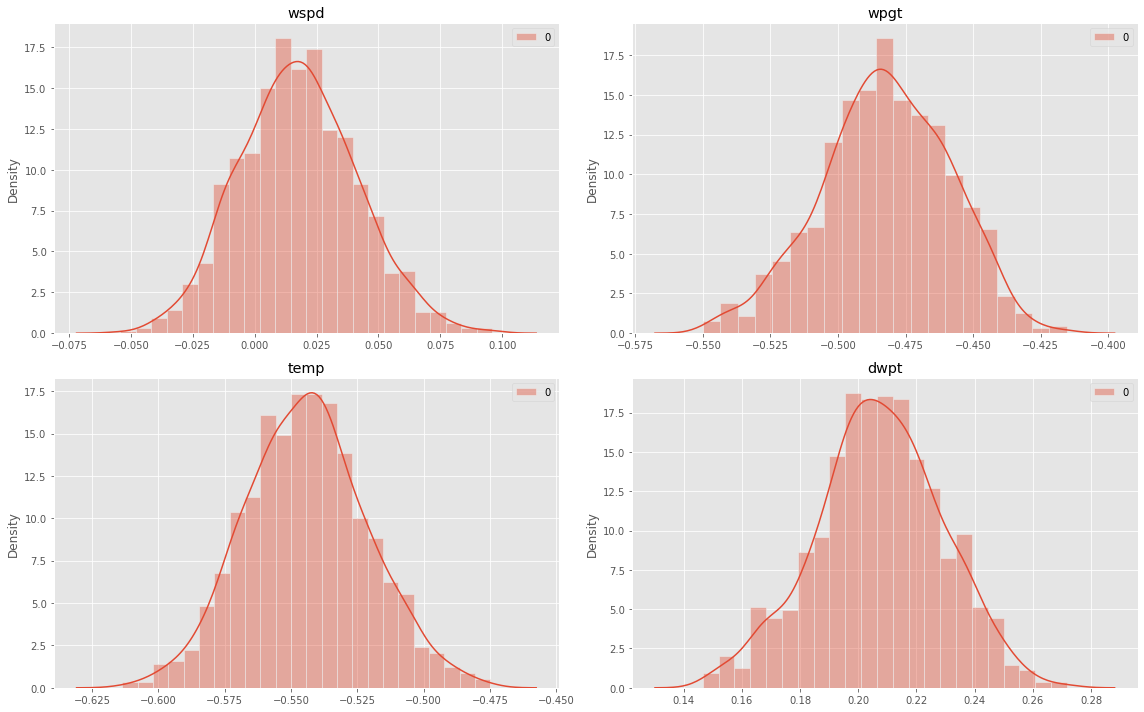

In [ ]:
nodes = X.columns[:4]

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    _, FD_bins = np.histogram(beta_samples[:,:,i], bins="fd")
    bin_nr = min(len(FD_bins)-1, 50)
    sns.histplot(beta_samples[:,:,i], stat='density', kde=True, kde_kws={"cut": 3}, ax=axes[i], alpha=0.4)
    fig.tight_layout()

Interestingly the wind speed shows a distribution with a center close to zero, and a much tighter spread, indicating tha this attribute might not contribute with consistent predictive ability. The remaining coefficients show distributions indicating a significant contribution.

If we take a look at the coefficients found by the two models, we see that the cosine similarity is very close to 1, showing that the models have found approximately the same coefficient values for all the attributes. 

In [ ]:
from scipy import spatial

a = mdl_LR.coef_
b = beta_samples.mean(axis=0).flatten()

cos_sim = result = 1 - spatial.distance.cosine(a, b)
print("Cosine similarity of coefficients from sklearn and pyro model: ", cos_sim)

Cosine similarity of coefficients from sklearn and pyro model:  0.9756313619701171


All in all it looks like we can at least match sklearn in performance. Let's now dive into the temporal aspects of the data to see if we can find ways to improve our model further, and outperform sklearn consistently!

<a name="part4"></a>
# 4 Temporal analysis

Before we start augmenting our model, we need to conduct a temporal analysis of the data, so we can perform the appropriate data processing for time series analysis.

<a name="part4.1"></a>
## 4.1 Stationarity of data and AR & MA order identification

One of the assumptions in temporal models is that the data is stationary - that the moments are constant through time. In other words, the mean and variance should be independent of the time-step. There are different ways of measuring stationariy. Some opt for the Augmented Dickey-Fuller test, while others prefer to look at ACF and PACF plots. The Augmented Dicker-Fuller is used to test for a unit root in a univariate process in the presence of serial correlation. If there is a unit root, then the series is not stationary. The null-hypothesis is that there is a unit root, thus if the p-value of the test is below our significance level we can reject the hypothesis. 

In [ ]:
pvalue = sts.adfuller(df['SpotPriceDKK'])[1]
print(f"Can we reject the null-hypothesis on 5% significance level? Yes! \np-value: {pvalue}" if pvalue < 0.05 else\
      "Can we reject the null-hypothesis on 5% significance level? no... np-value: {pvalue}")

Can we reject the null-hypothesis on 5% significance level? Yes! 
p-value: 1.012472007073858e-21


The Augmented Dicker-Fuller test indicates that the time series is stationary... However, with the information gathered in the descriptive part we know that there exists daily and weekly pattern. Thus, an analysis of the ACF and PACF is probably a good thing to conduct.

In [ ]:
# Plot to display the time series, ACF and PACF
# This code was adapted from the blog Seanabu.com
def tsplot(y, lags=25, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        plt.figure(figsize=figsize) # Set the size of the figure
        
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')


        plt.tight_layout()
    return 

In [ ]:
#create pd series with only spotprice
ts = df['SpotPriceDKK']

**A small recap of the expected behaviour of the ACF and PACF**


As the authors of this project has taken the course "Time Series Analysis" at DTU, the knowledge accumulated will ofcourse be used in the next part. The approach used is based on the book *Time Series Analysis* by Henrik Madsen. The goal of the next session is thus to ensure that the time series is stationary by differencing the data. 

The differencing of the data is done in an iterative manner - eliminating one "structure" at a time. If the ACF systematically decays with a given period, it is a clear indication that the time series should be differenced with that period.

Initially, the time series, ACF and PACF are plotted. The ACF and PACF are plotted for the last 75 lags/hours to ensure that patterns can be seen. One may argue that even more lags should be included to account for weekly patterns.

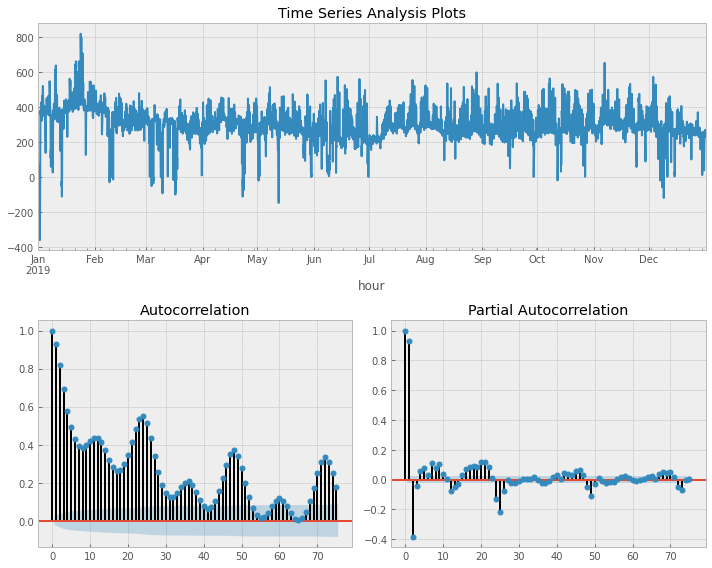

In [ ]:
tsplot(ts, lags = 75)

It is clear that the ACF shows an "exponential" decay. Thus, a differencing with period 1 is necessary.

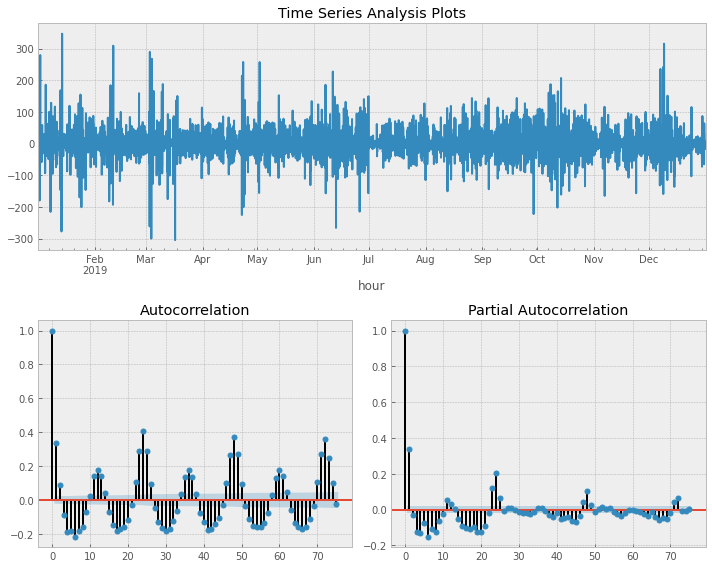

In [ ]:
ts_diff = ts.diff(periods=1).dropna()
tsplot(ts_diff,lags =75)

Looking at the ACF and PACF after having differenced the data once, it is clear that there still are a daily pattern - let's remove it by differencing with a period of 24.

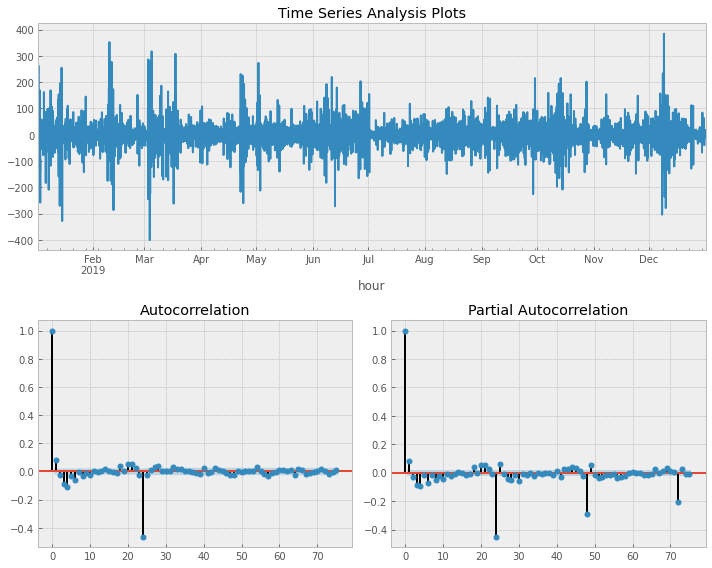

In [ ]:
ts_diff2 = ts.diff(periods=1).diff(periods=24).dropna()
tsplot(ts_diff2, lags = 75)

Much better! It now shows no clear signs of non-stationarity. We can now analyse the ACF and PACF to determine the order of AR and MA components. If there is a significant lag it indicates that an AR or MA part should be included with that order.

It is clear that there are several significant spikes at lag 1 to 10 at both the ACF and PACF and also a significant spike on the ACF at lag 24. This indicates that a mix of AR and MA terms of order between 1 and 10 are required  to combat the spikes at lag 1 to 10. The best practice is to start with a small model and iteratively look at the residuals and capture the structure with additional AR and MA orders. The spike at lag 24 is clearly best modelled with an MA part as the PACF at lag 24, 48 and 72 slowly decays.

As the temporal models do not allow for MA terms, we only have the option to include AR terms. However, this is not the end of the world - we might still be able to capture some of the structure by using e.g. an AR(2) with a seasonal AR(1) with period 24 - denoted by AR(2)xAR(1)$_{24}$.

To conclude, we should double difference our time series and start out with a small model such as an AR(2). Thus, the prediction of the spot price should occur in the double differenced domain and be transformed back to the original domain for evaluation. Why don't we difference our data first, and afterwards create a function that can restore it. This way we can easily evaluate our models!

From the output below you can see that the inverse differenciation works. Note that we throw away 25 observations due to the transformation - however, this is nothing compared to the amount of observations we have.

In [ ]:
ts = df[["SpotPriceDKK"]].copy()

# Standardize based on training set
ts_mean = ts[:"2019-10-01"].mean()
ts_std = ts[:"2019-10-01"].std()
ts["SpotPriceDKK_std"] = (ts - ts_mean)/ts_std

#diff in standardized domain
ts["diff1"] = ts["SpotPriceDKK_std"].diff(1)    # Transform with 1h diff
ts["diff2"] = ts["diff1"].diff(24)              # Transform with 24h diff

#create function that transforms back into original domain
def getPriceDomain(df):
  diff1 = df['diff1'].shift(24) + df['diff2']     # Reverse the 24h diff
  ori = df['SpotPriceDKK_std'].shift(1) + diff1   # Reverse the 1h diff
  return ori


ts["ori_std"] = getPriceDomain(ts)
ts.iloc[24:,:]

,SpotPriceDKK,SpotPriceDKK_std,diff1,diff2,ori_std
hour,,,,,
2019-01-02 00:00:00,-250.65,-5.629926,-0.355581,NaN,NaN
2019-01-02 01:00:00,-342.87,-6.577115,-0.947188,0.452539,-6.577115
2019-01-02 02:00:00,-360.56,-6.758808,-0.181693,0.903639,-6.758808
2019-01-02 03:00:00,-250.88,-5.632289,1.126519,1.573614,-5.632289
2019-01-02 04:00:00,-250.43,-5.627667,0.004622,-0.187137,-5.627667
...,...,...,...,...,...
2019-12-31 19:00:00,252.84,-0.458599,-0.125100,0.093466,-0.458599
2019-12-31 20:00:00,250.53,-0.482325,-0.023726,0.045398,-0.482325
2019-12-31 21:00:00,247.76,-0.510775,-0.028451,0.048992,-0.510775


<a name="part5"></a>
# 5 AR model

<a name="part5.1"></a>
## 5.1 AR(2)

The first temporal model we will define is a simple AR(2). A $\beta$ coefficient is sampled for each AR term, as well as a noise value for each timestep, resulting in the following generative process:

1. Sample AR coefficients and noise variance

  *   $\beta_1$ ~ $N(\beta_1 | 0, 3)$
  *   $\beta_2$ ~ $N(\beta_2 | 0, 3)$
  *   $\tau$ ~ $HalfCauchy(\tau | 3)$
2. Sample initial hidden states:
  *   $z_{1}$ ~ $N(z_{1}|0, 5)$
  *   $z_{2}$ ~ $N(z_{2}|0, 5)$
3. For each timestep $t=\{3, ..., T\}$:
  *   $z_{t}$ ~ $N(z_t | \beta_1 z_{t-1} + \beta_2 z_{t-2},  \tau)$
  *   $y_t$ ~ $N(y_t | z_t, \sigma)$

The model is defined along with the carry function for the lax scan procedure. Generally for all models throughout the notebook, the scales have initially been set to values similar to those used in playtime exercises, but have been iteratively adjusted based on model performance throughout the project. This was done by trial and error, and is therefore not documented is this notebook. In the actual implementation, the noise is sampled for each timestep beforehand and $z_t$ is calculated directly with the noise being scaled by $\tau$, which is completely equivalent to the sampling of $z_t$ described in the generative above. 

In [ ]:
def f(carry, noise_t):
    beta1, beta2, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau), z_t

In [ ]:
def model(T, T_forecast, obs=None):
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=3.))
    beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=3.))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(T+T_forecast-2,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=1.))
    z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=5.))
    z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0, scale=5.))    

    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

<a name="part5.2"></a>
## 5.2 Ancestral sampling

Since the model is significantly more complex than the previous, good practice requires a verification of the defined model. This is done by using ancestral sampling, where parameters are defined with fixed values, which then are used to generate some data. When the model is trained on the generated data, it should be able to retrieve the original parameter values we defined. If the correct values are found at least approximately, the model can be considered valid, and we can continue to use it on our actual data, knowing that the parameters retrieved fit an equivalent data generation process as the real data - to a reasonable degree of course. Let's do it!

The first step is the data generation:

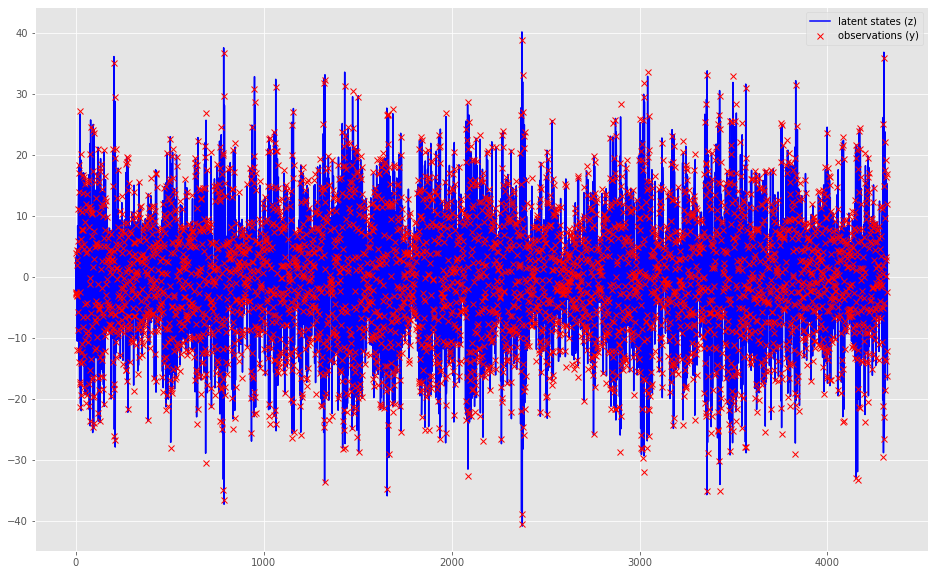

In [ ]:
# Define fixed values for tau, sigma, beta1 and beta2.
# The values of beta1 and beta2 are chosen such that they ensure a stationary time series. 
beta1 = 0.25
beta2 = -0.9
tau = 5
sigma = 1

# We want to generate 180 days worth of data, and then we initialize the first two hidden states randomly.
T = 180*24 
z = [np.random.normal(0, tau), np.random.normal(0,tau)]
y = []


# We sample latent states for each time step using the fixed parameters
for t in range(2,T):
  z.append(np.random.normal(beta1*z[t-1] + beta2*z[t-2], tau))

# We sample observations based on the latent states
for t in range(T):
  y.append(np.random.normal(z[t], sigma))

y = np.array(y)
z = np.array(z)

# Finally we plot the sampled data
plt.plot(range(T), z, "b-")
plt.plot(range(T), y, "rx")
plt.legend(["latent states (z)", "observations (y)"])
plt.show()

With our data generated, we split the samples into a training set consisting of the first 170 days, leaving the remaining 10 days as a test set.

In [ ]:
ix_train = range(0, 24*170)
ix_test = range(24*170, 24*180)
N_train = len(ix_train)
N_test = len(ix_test)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y[ix_train]
y_test = y[ix_test]

N_train: 4080
N_test: 240


Now we are ready to test it out! We choose to run the MCMC algorithm to train the model. We are using numpyro functions here, so let's make sure we have the right imports.

In [ ]:
#numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

We are probably gonna run this kind of algorithm several times, so lets make it into a function for future use.

In [ ]:

def run_MCMC(model, y_train, T, T_forecast, num_samples=4000, num_warmup=1000, print_summary=False):
  t0 = time.time()

  rng_key = random.PRNGKey(0)
  rng_key, rng_key_ = random.split(rng_key)

  nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
  mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=1)
  mcmc.run(rng_key_, T=T, T_forecast=T_forecast, obs=y_train)

  t_fin = time.time()

  print("Total time: {0:.3f}m".format((t_fin - t0)/60))

  if print_summary:
    mcmc.print_summary()

  return mcmc

In [ ]:
mcmc = run_MCMC(model, y_train, N_train, N_test)

sample: 100%|██████████| 5000/5000 [06:09<00:00, 13.54it/s, 255 steps of size 5.00e-03. acc. prob=0.98]


Total time: 6.311m


Now that the model has trained, we retrieve the coefficient samples and plot the distribution along with the true value we defined before generating the data.

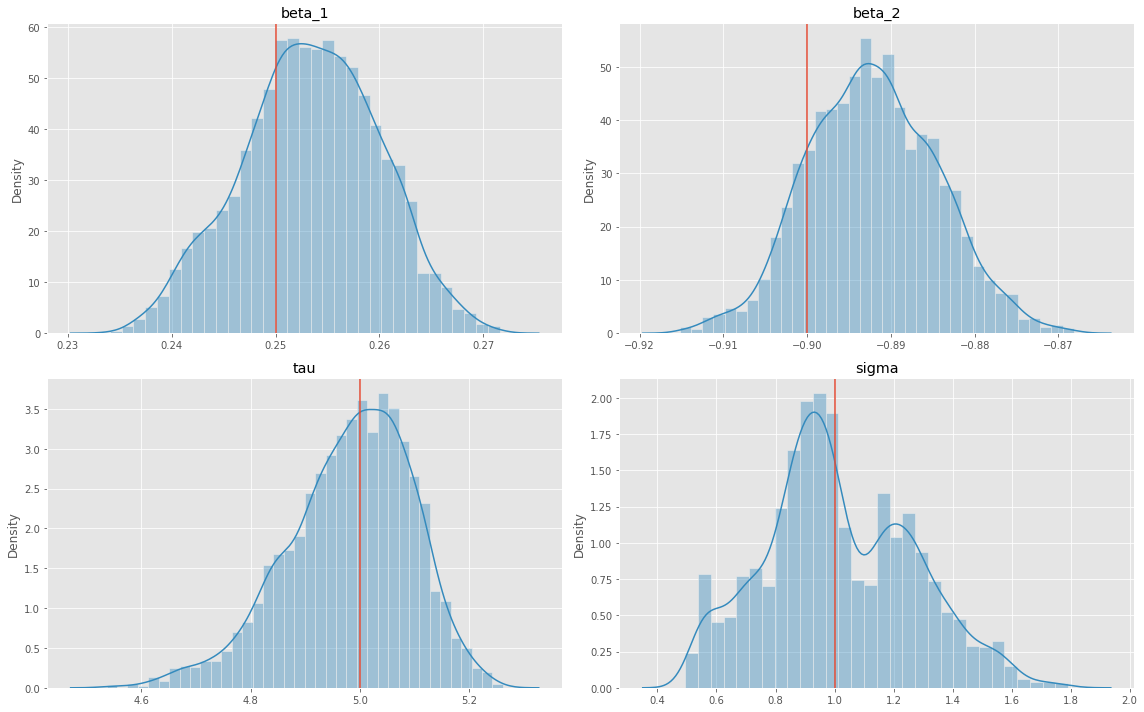

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

nodes = ["beta_1", "beta_2", "tau", "sigma"]
true_values = [beta1, beta2, tau, sigma]

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    _, FD_bins = np.histogram(hmc_samples[node], bins="fd")
    bin_nr = min(len(FD_bins)-1, 50)
    sns.histplot(hmc_samples[node], label=node, stat='density', kde=True, kde_kws={"cut": 3}, ax=axes[i], alpha=0.4, bins = bin_nr)
    axes[i].axvline(x=true_values[i])
    fig.tight_layout()



Note that the axis intervals are such that the plot looks nice, and the distribution modes are actually very close to the true parameter values! Lets take a closer look at the values found. 

In [ ]:
import statistics
nodes = ["beta_1", "beta_2", "tau", "sigma"]
modes = []
for node in nodes:
  mode = pd.DataFrame(np.array(hmc_samples[node])).mode().mean()[0]
  modes.append(mode)


for i, param in enumerate(true_values):
  print(f"True {nodes[i]}: {param}")
  print(f"Mode of dist.: {modes[i] : .2f}")
  print(f"Deviation: {(modes[i]-param)/param*100 : .2f} %")
  print("\n")

True beta_1: 0.25
Mode of dist.:  0.25
Deviation:  1.49 %


True beta_2: -0.9
Mode of dist.: -0.89
Deviation: -1.09 %


True tau: 5
Mode of dist.:  4.99
Deviation: -0.14 %


True sigma: 1
Mode of dist.:  1.01
Deviation:  1.40 %




The model estimates all the parameters within 1.5%, that's definitely a validation! 
This means we can finally test out the model on the real data. Let's do it!

<a name="part5.3"></a>
## 5.3 Real data

Let's try to predict the price for the last three months of 2019.

In [ ]:
# Split dataset
y_train = ts["diff2"][:"2019-10-01"].dropna().to_numpy()
y_test = ts["diff2"]["2019-10-01":].to_numpy()


# Run algorithm
mcmc = run_MCMC(model, y_train, len(y_train), len(y_test))

sample: 100%|██████████| 5000/5000 [14:23<00:00,  5.79it/s, 255 steps of size 5.00e-03. acc. prob=1.00]


Total time: 14.579m


Let's take a look at the resulting distributions.

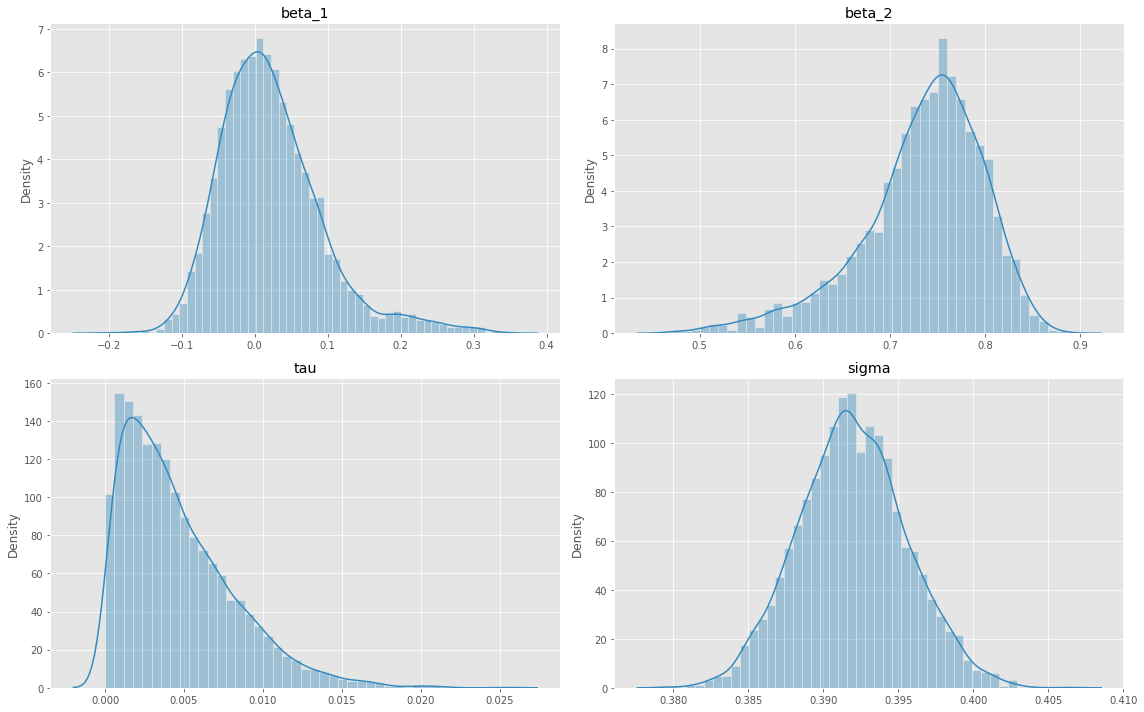

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

nodes = ["beta_1", "beta_2", "tau", "sigma"]

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    _, FD_bins = np.histogram(hmc_samples[node], bins="fd")
    bin_nr = min(len(FD_bins)-1, 50)
    sns.histplot(hmc_samples[node], label=node, stat='density', kde=True, kde_kws={"cut": 3}, ax=axes[i], alpha=0.4)#, bins = bin_nr)
    fig.tight_layout()

Interesting! $\beta_1$ looks like it has a mean of 0, meaning the latent state in $t-1$ has a small and perhaps noisy influence, especially compared to the value of $\beta_2$. Note that this is not 1h and 2h before the timestep since we are in the double differenciated domain, so it is not directly interpretable as hours of lag.
$\tau$ has a large density towards zero, indicating that the noise between latent states is very low, but remember that $z_t$ is the mean of the Gaussian $y_t$ sample that has variance $\sigma$, meaning that $z$ and $y$ can be expected to "share noise" so to say, and the model is in some sense accounting for this noise in both $\tau$ and $\sigma$, meaning one of them is expected to be zero while the other "captures" all the noise. 

Let's see how well our model predicts on the test data!

In [ ]:
prediction_samples = hmc_samples["y_pred"]                          # retrieve predictions
temp_list = []
temp_list.extend(np.full(1, np.nan))
temp_list.extend(y_train)
temp_list.extend(prediction_samples.T)
ts_results = ts.copy()
ts_results["diff2"] = temp_list                                                     # update dataframe with predictions
ts_results["pred_std"] = getPriceDomain(ts_results)                                 # transform predictions to non-differenced domain
ts_results["pred"] = ts_results["pred_std"]*ts_std.values[0] + ts_mean.values[0]    # transform to non-standardized domain

In [ ]:
from operator import add, sub
y_pred = [i.mean() for i in ts_results['pred']["2019-10-01":]]
y_std = [1.96*i.std() for i in ts_results['pred']["2019-10-01":]]

y_pred_025 = list(map(sub, y_pred, y_std) )
y_pred_975 = list(map(add, y_pred, y_std) )
y_true = ts_results["SpotPriceDKK"]["2019-10-01":]
test_index = y_true.index

N_train = len(y_train)
N_test = len(y_test)

price_train = ts_results["SpotPriceDKK"][:"2019-10-01"]
price_test = ts_results["SpotPriceDKK"]["2019-10-01":]



fig=go.Figure()
fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_975,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_025,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=True
    ))

fig.add_trace(go.Scatter(name="true train",x=np.arange(6300,N_train) , y=price_train[6300:], marker_color="blue", showlegend=True))

fig.add_trace(go.Scatter(name="forecast",x=np.arange(N_train,N_train+N_test), y=y_pred, marker_color="red", showlegend=True))
fig.add_trace(go.Scatter(mode="markers",name="true (test)",x=np.arange(N_train,N_train+N_test), y=price_test, marker_color="blue", showlegend=True))
fig.show()


The plot above is interactive, so you can zoom in to better see the results! We recommend to zoom in on sample 8000 and forward, where you can see both some great predictions of variation, as well as som places where the model predicts varation wrongly.

This plot shows some amazing results! The negative prices which we thought were outliers and well beyond the capability of the model is actually predicted every time! This is way beyond our expectation. Let's check out the scores so we can compare to earlier models.

In [ ]:
get_score(y_true, y_pred)

CorrCoeff:  0.9168413259473166
MAE:  0.34799723197432003
RMSE:  35.82503202322374
R2:  0.8231112000746986


That is some truly unexpected results. The AR(2) model hugely outperforms sklearn and Bayesian regression!

Let's check out the residuals to see if there is some recognizable structure.

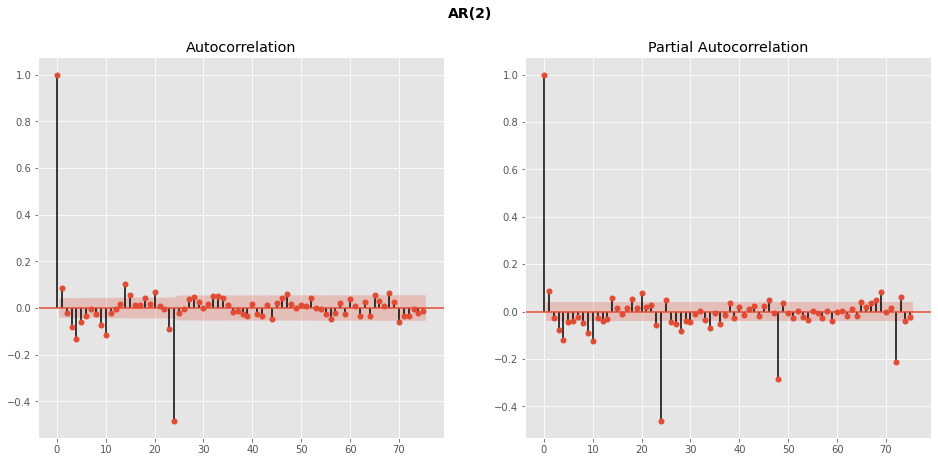

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
plot_acf(y_true-y_pred, ax=ax[0], lags = 75);
plot_pacf(y_true-y_pred, ax=ax[1], lags = 75);
fig.suptitle("AR(2)", fontsize=14, weight="bold");

We clearly see the 24h mark stick out, which is consistent with what we found earlier. Let's try to improve our model by including the price from 24h earlier!

<a name="part5.4"></a>
## 5.4 AR(2) + AR(1)$_{24}$

The notation in the title indicates that we want to include the 24h lag term, but not all the remaining 22 terms between AR(2) and AR(24), we basically have an AR(2) model plus a 24 period lagged AR(1) model. 

We define the new carry function and model, and unfortunately it looks a bit messy because we need to "remember" all values between $t-2$ and $t-24$ even though we don't use them in the equation. The only new parameter is $\beta_{24}$, and of course we now need to sample the first 24 hidden states randomly before we can begin the training. Fortunately, we have more than enough data points so it makes no difference to lose the first 24.

In [ ]:
def f(carry, noise_t):
    beta1, beta2, beta24, z_prev1, z_prev2 ,z_prev3 ,z_prev4 ,z_prev5 ,z_prev6 ,z_prev7 ,z_prev8 ,z_prev9 ,z_prev10,z_prev11,z_prev12,z_prev13,z_prev14,z_prev15,z_prev16,z_prev17,z_prev18,z_prev19,z_prev20,z_prev21,z_prev22,z_prev23,z_prev24, tau = carry


    z_t = beta1*z_prev1 + beta2*z_prev2 + beta24*z_prev24 + tau*noise_t
    z_prev24 = z_prev23
    z_prev23 = z_prev22
    z_prev22 = z_prev21
    z_prev21 = z_prev20
    z_prev20 = z_prev19
    z_prev19 = z_prev18
    z_prev18 = z_prev17
    z_prev17 = z_prev16
    z_prev16 = z_prev15
    z_prev15 = z_prev14
    z_prev14 = z_prev13
    z_prev13 = z_prev12
    z_prev12 = z_prev11
    z_prev11 = z_prev10
    z_prev10 = z_prev9
    z_prev9 = z_prev8
    z_prev8 = z_prev7
    z_prev7 = z_prev6
    z_prev6 = z_prev5
    z_prev5 = z_prev4
    z_prev4 = z_prev3
    z_prev3 = z_prev2
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, beta24, z_prev1, z_prev2 ,z_prev3 ,z_prev4 ,z_prev5 ,z_prev6 ,z_prev7 ,z_prev8 ,z_prev9 ,z_prev10,z_prev11,z_prev12,z_prev13,z_prev14,z_prev15,z_prev16,z_prev17,z_prev18,z_prev19,z_prev20,z_prev21,z_prev22,z_prev23,z_prev24, tau), z_t

In [ ]:
def model(T, T_forecast, obs=None):
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=3.))
    beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=3.))
    beta24 = numpyro.sample(name="beta_24", fn=dist.Normal(loc=0., scale=3.))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(T+T_forecast-24,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=3.))
    z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=5.))
    z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0, scale=5.))
    z_prev3 = numpyro.sample(name="z_3", fn=dist.Normal(loc=0, scale=5.))
    z_prev4 = numpyro.sample(name="z_4", fn=dist.Normal(loc=0, scale=5.))
    z_prev5 = numpyro.sample(name="z_5", fn=dist.Normal(loc=0, scale=5.))
    z_prev6 = numpyro.sample(name="z_6", fn=dist.Normal(loc=0, scale=5.))
    z_prev7 = numpyro.sample(name="z_7", fn=dist.Normal(loc=0, scale=5.))
    z_prev8 = numpyro.sample(name="z_8", fn=dist.Normal(loc=0, scale=5.))
    z_prev9 = numpyro.sample(name="z_9", fn=dist.Normal(loc=0, scale=5.))
    z_prev10 = numpyro.sample(name="z_10", fn=dist.Normal(loc=0, scale=5.))
    z_prev11 = numpyro.sample(name="z_11", fn=dist.Normal(loc=0, scale=5.))
    z_prev12 = numpyro.sample(name="z_12", fn=dist.Normal(loc=0, scale=5.))
    z_prev13 = numpyro.sample(name="z_13", fn=dist.Normal(loc=0, scale=5.))
    z_prev14 = numpyro.sample(name="z_14", fn=dist.Normal(loc=0, scale=5.))
    z_prev15 = numpyro.sample(name="z_15", fn=dist.Normal(loc=0, scale=5.))
    z_prev16 = numpyro.sample(name="z_16", fn=dist.Normal(loc=0, scale=5.))
    z_prev17 = numpyro.sample(name="z_17", fn=dist.Normal(loc=0, scale=5.))
    z_prev18 = numpyro.sample(name="z_18", fn=dist.Normal(loc=0, scale=5.))
    z_prev19 = numpyro.sample(name="z_19", fn=dist.Normal(loc=0, scale=5.))
    z_prev20 = numpyro.sample(name="z_20", fn=dist.Normal(loc=0, scale=5.))
    z_prev21 = numpyro.sample(name="z_21", fn=dist.Normal(loc=0, scale=5.))
    z_prev22 = numpyro.sample(name="z_22", fn=dist.Normal(loc=0, scale=5.))
    z_prev23 = numpyro.sample(name="z_23", fn=dist.Normal(loc=0, scale=5.))
    z_prev24 = numpyro.sample(name="z_24", fn=dist.Normal(loc=0, scale=5.))

    


    carry = (beta1, beta2, beta24, z_prev1, z_prev2 ,z_prev3 ,z_prev4 ,z_prev5 ,z_prev6 ,z_prev7 ,z_prev8 ,z_prev9 ,z_prev10,z_prev11,z_prev12,z_prev13,z_prev14,z_prev15,z_prev16,z_prev17,z_prev18,z_prev19,z_prev20,z_prev21,z_prev22,z_prev23,z_prev24, tau)
    z_collection = [z_prev1, z_prev2 ,z_prev3 ,z_prev4 ,z_prev5 ,z_prev6 ,z_prev7 ,z_prev8 ,z_prev9 ,z_prev10,z_prev11,z_prev12,z_prev13,z_prev14,z_prev15,z_prev16,z_prev17,z_prev18,z_prev19,z_prev20,z_prev21,z_prev22,z_prev23,z_prev24]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-24)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

In [ ]:
# Split dataset
y_train = ts["diff2"][:"2019-10-01"].dropna().to_numpy()
y_test = ts["diff2"]["2019-10-01":].to_numpy()


# Run algorithm
mcmc = run_MCMC(model, y_train, len(y_train), len(y_test))

sample: 100%|██████████| 5000/5000 [17:58<00:00,  4.64it/s, 12 steps of size 5.00e-03. acc. prob=0.29]


Total time: 18.360m


Let's take a look at the parameter distributions. 

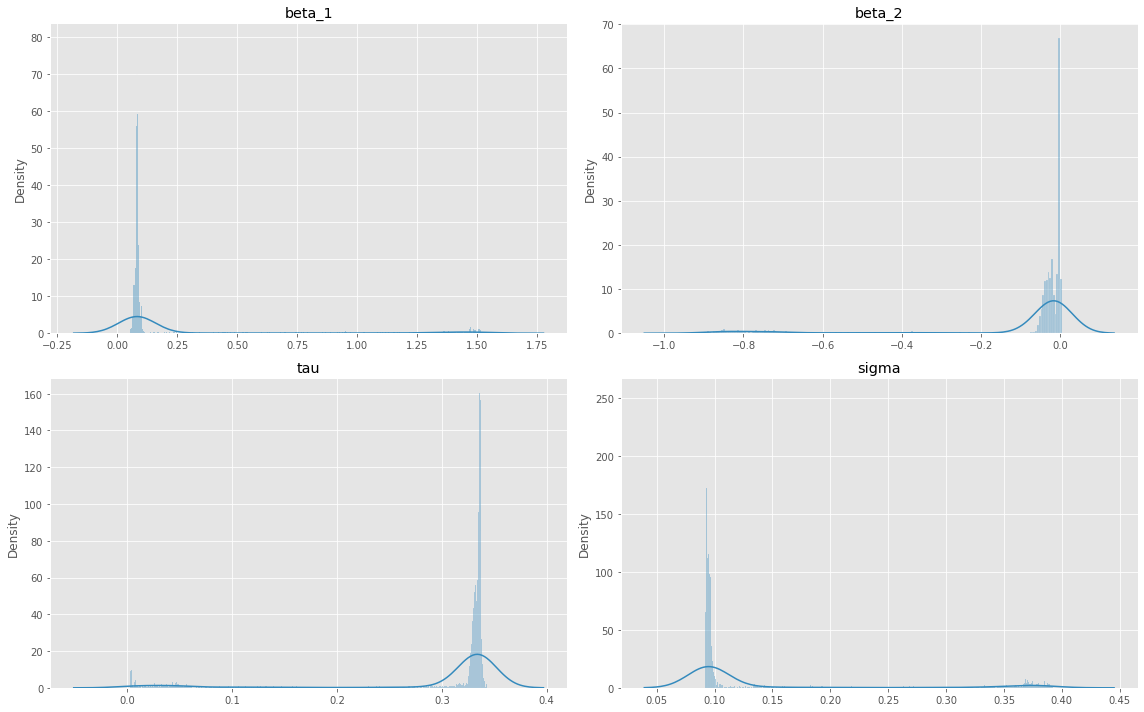

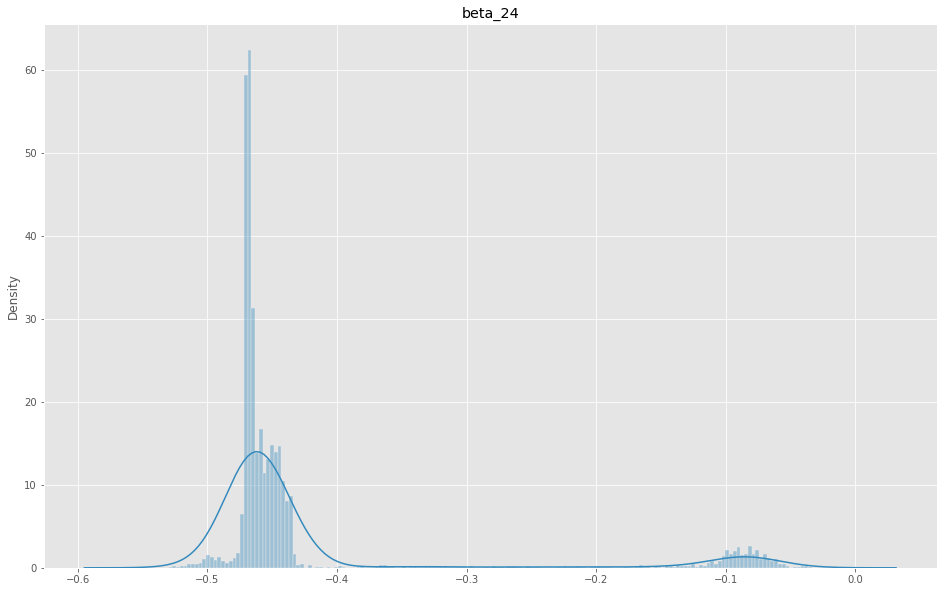

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

nodes = ["beta_1", "beta_2", "tau", "sigma"]

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    _, FD_bins = np.histogram(hmc_samples[node], bins="fd")
    bin_nr = min(len(FD_bins)-1, 50)
    sns.histplot(hmc_samples[node], label=node, stat='density', kde=True, kde_kws={"cut": 3}, ax=axes[i], alpha=0.4)#, bins = bin_nr)
    fig.tight_layout()


f2, axis = plt.subplots(1, 1)
axis.set_title("beta_24")
_, FD_bins = np.histogram(hmc_samples["beta_24"], bins="fd")
bin_nr = min(len(FD_bins)-1, 50)
sns.histplot(hmc_samples["beta_24"], label="beta_24", stat='density', kde=True, kde_kws={"cut": 3}, ax=axis, alpha=0.4)

Now we see $\beta_{24}$ with a relatively large negative value, but $\beta_1$ and $\beta_2$ is much closer to 0. There is a small interesting amount of samples around -0.1 for $\beta_{24}$ - perhaps there is a non-linear relationship with some (unknown) attribute that determines whether the price 24h previous should have a parameter of ~(-0.45) or ~(-0.1).


We create an interactive plot like before:

In [ ]:
prediction_samples = hmc_samples["y_pred"]                          # retrieve predictions
temp_list = []
temp_list.extend(np.full(1, np.nan))
temp_list.extend(y_train)
temp_list.extend(prediction_samples.T)
ts_results = ts.copy()
ts_results["diff2"] = temp_list                                                     # update dataframe with predictions
ts_results["pred_std"] = getPriceDomain(ts_results)                                 # transform predictions to non-differenced domain
ts_results["pred"] = ts_results["pred_std"]*ts_std.values[0] + ts_mean.values[0]    # transform to non-standardized domain

In [ ]:

y_pred = [i.mean() for i in ts_results['pred']["2019-10-01":]]
y_std = [1.96*i.std() for i in ts_results['pred']["2019-10-01":]]

y_pred_025 = list(map(sub, y_pred, y_std) )
y_pred_975 = list(map(add, y_pred, y_std) )
y_true = ts_results["SpotPriceDKK"]["2019-10-01":]
test_index = y_true.index

N_train = len(y_train)
N_test = len(y_test)

price_train = ts_results["SpotPriceDKK"][:"2019-10-01"]
price_test = ts_results["SpotPriceDKK"]["2019-10-01":]



fig=go.Figure()
fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_975,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_025,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=True
    ))

fig.add_trace(go.Scatter(name="true train",x=np.arange(6300,N_train) , y=price_train[6300:], marker_color="blue", showlegend=True))

fig.add_trace(go.Scatter(name="forecast",x=np.arange(N_train,N_train+N_test), y=y_pred, marker_color="red", showlegend=True))
fig.add_trace(go.Scatter(mode="markers",name="true (test)",x=np.arange(N_train,N_train+N_test), y=price_test, marker_color="blue", showlegend=True))
fig.show()


It's hard to say whether this is any better than before. Let's take a look at the scores.

In [ ]:
get_score(y_true, y_pred)

CorrCoeff:  0.8988256726561167
MAE:  0.4402530438853821
RMSE:  40.054059535503384
R2:  0.7788839645368549


The score is actually a bit worse than before. Let's take a final look at the residuals again before we begin the final model.

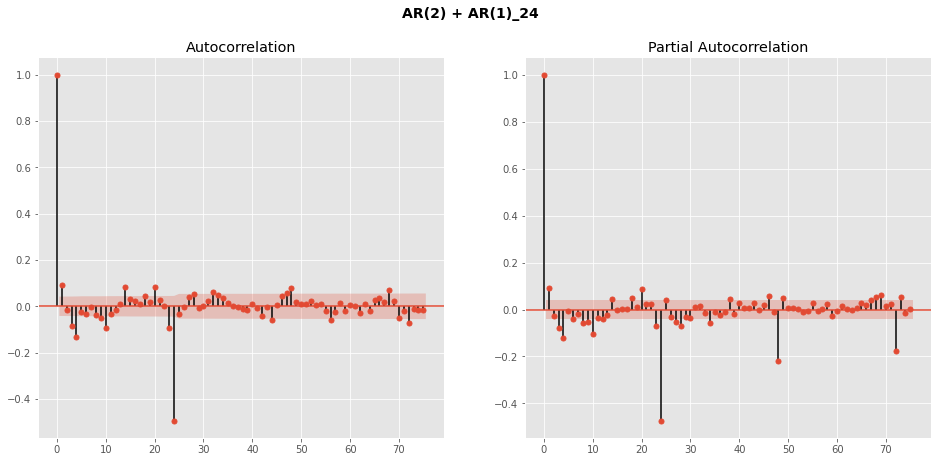

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
plot_acf(y_true-y_pred, ax=ax[0], lags = 75);
plot_pacf(y_true-y_pred, ax=ax[1], lags = 75);
fig.suptitle("AR(2) + AR(1)_24", fontsize=14, weight="bold");

As hinted in the original ACF and PACF analysis, the AR(24) component is not completely capable of accounting for this, it requires an MA component as well - this is left for future work. 

Let's include the weather data as well to get our final model!

<a name="part6"></a>
# 6 Final model

The final model adds the $X$ data with both weather and original time data on top of the AR(2) model, since that performed better than when we included the AR(1)$_{24}$ term, thus utilizing all the predictive power possible. This means we both account for time by the dummy variables in $X$ as well as the AR terms. Let's do it!

The carry function and model definition is modified so we have a tuple consisting of an $x_t$-vector with weather and time data and the noise value, instead of only the noise. 

We lost the first 25 values when we entered the differenciated temporal domain, so we define an offset to account for that in our $X$-vector so we can offset correctly in the model. We also have an offset for the 2 initial $z$ values that we need to sample. 

In [ ]:
X_train = X[:"2019-10-01"].to_numpy()
X_test = X["2019-10-01":].to_numpy()
y_train = ts['diff2'][:"2019-10-01"].to_numpy()
y_test = ts['diff2']["2019-10-01":].to_numpy()
X_total = X.to_numpy()

N_train = len(y_train)
N_test = len(y_test)

offset1 = 2
offset2 = 25

In [ ]:
def f(carry, input_t):
    beta1, beta2, z_prev1, z_prev2, W, tau = carry
    x_t = input_t[0]
    noise_t = input_t[1]
    z_t = beta1*z_prev1 + beta2*z_prev2 + jnp.dot(W,x_t) + tau*noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, W, tau), z_t

In [ ]:
def model(T, T_forecast, xs, obs=None):
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=3.))
    beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=3.))
    W = numpyro.sample(name="w", fn=dist.Normal(loc=np.zeros(X_train.shape[1]), scale=np.ones(X_train.shape[1])*3.))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(T+T_forecast-offset1,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=1.))
    z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=5.))
    z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0, scale=5.))    

    inputs = (xs[offset1:,:],noises)

    carry = (beta1, beta2, z_prev1, z_prev2, W, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f, carry, inputs, T+T_forecast-offset1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

We now have to input our weather data in our model, so we can't reuse the MCMC function from before directly. We use the same hyperparameters though, so the only new thing is the weather data in the $X$ variable.

In [ ]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train-offset2, T_forecast=N_test, xs=X_total, obs=y_train[offset2:])

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))


sample: 100%|██████████| 5000/5000 [27:03<00:00,  3.08it/s, 255 steps of size 5.00e-03. acc. prob=0.91]


Total time: 27.188m


Let's first plot the usual distributions of $\beta$ and the variances.

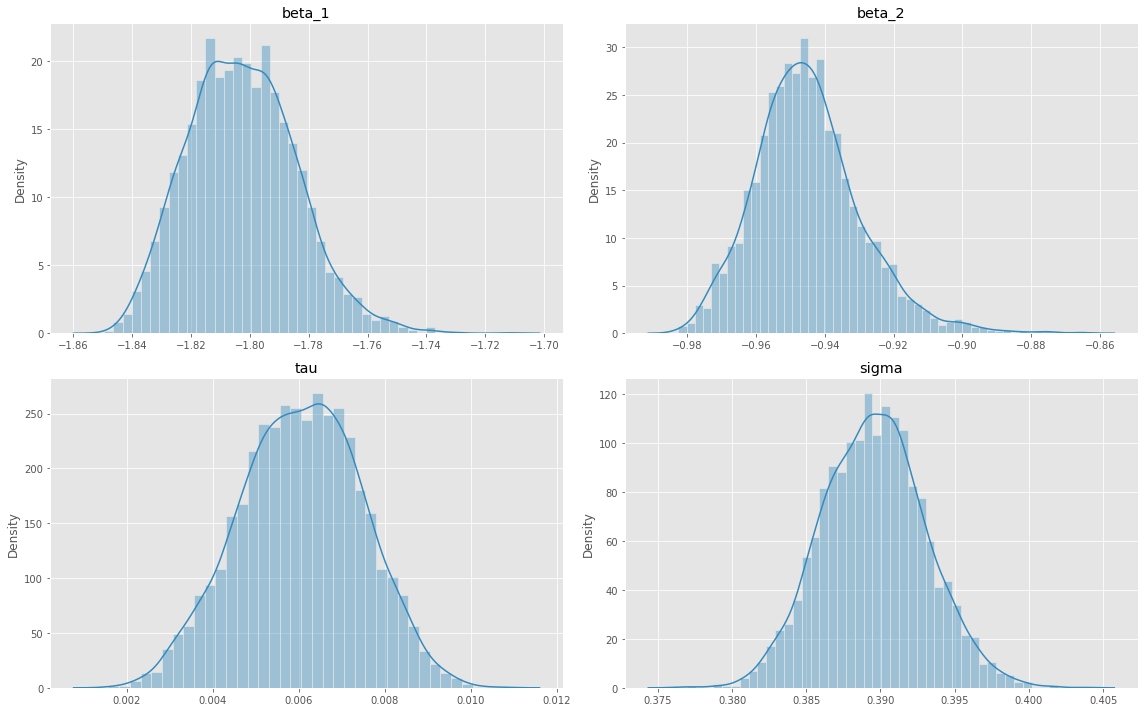

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

nodes = ["beta_1", "beta_2", "tau", "sigma"]

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    _, FD_bins = np.histogram(hmc_samples[node], bins="fd")
    bin_nr = min(len(FD_bins)-1, 50)
    sns.histplot(hmc_samples[node], label=node, stat='density', kde=True, kde_kws={"cut": 3}, ax=axes[i], alpha=0.4)#, bins = bin_nr)
    fig.tight_layout()


Now we have both $\beta$ values taking a value significantly different from 0, and $\tau$ again takes a very small value, indicating that $\sigma$ accounts for all the randomness in the observations. 

$W$ has 35 attributes, so let's stick to plotting the distributions of the weather data.

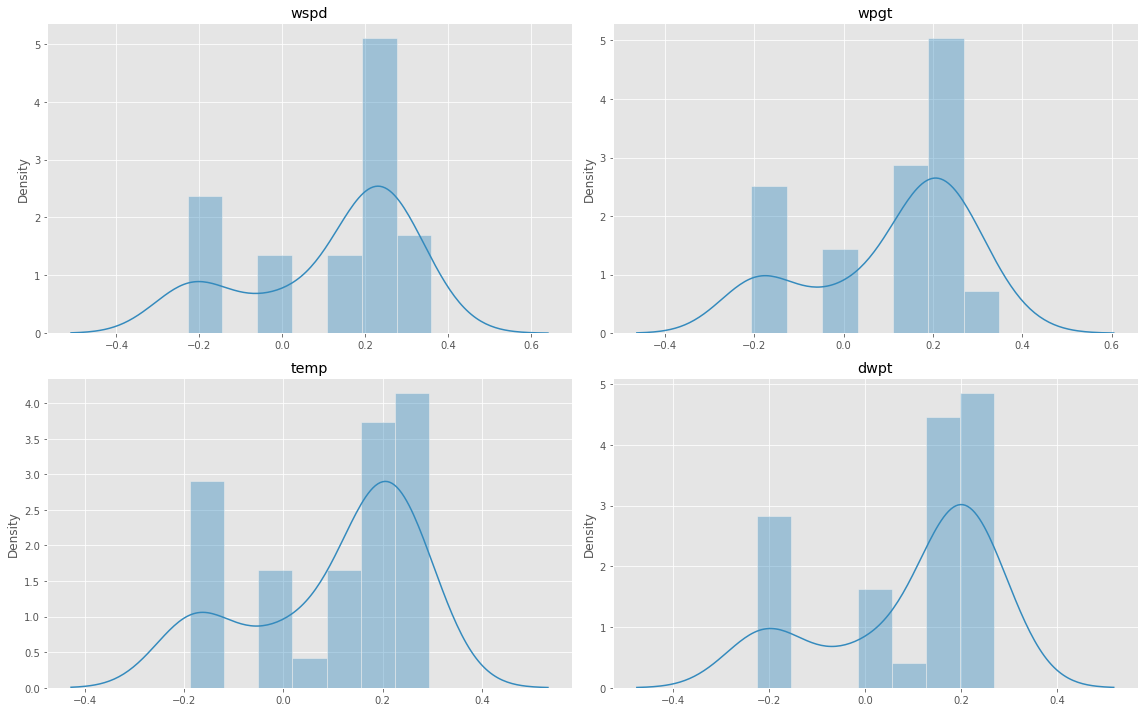

In [ ]:

nodes = X.columns[:4]

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    _, FD_bins = np.histogram(hmc_samples["w"][i], bins="fd")
    bin_nr = min(len(FD_bins)-1, 50)
    sns.histplot(hmc_samples["w"][i], label=node, stat='density', kde=True, kde_kws={"cut": 3}, ax=axes[i], alpha=0.4)#, bins = bin_nr)
    fig.tight_layout()

All the weather attributes have very similar distributions, and shows a mode on either side of 0. This indicates that the weather attributes might not contribute with any consistent improvement.

Let's create the final plot and get the model scores.

In [ ]:
prediction_samples = hmc_samples["y_pred"]                          # retrieve predictions
temp_list = []
temp_list.extend(np.full(1, np.nan))
temp_list.extend(y_train[offset2:])
temp_list.extend(prediction_samples.T)
ts_results = ts.copy()
ts_results["diff2"] = temp_list                                                     # update dataframe with predictions
ts_results["pred_std"] = getPriceDomain(ts_results)                                 # transform predictions to non-differenced domain
ts_results["pred"] = ts_results["pred_std"]*ts_std.values[0] + ts_mean.values[0]    # transform to non-standardized domain

In [ ]:
y_pred = [i.mean() for i in ts_results['pred']["2019-10-01":]]
y_std = [1.96*i.std() for i in ts_results['pred']["2019-10-01":]]

y_pred_025 = list(map(sub, y_pred, y_std) )
y_pred_975 = list(map(add, y_pred, y_std) )
y_true = ts_results["SpotPriceDKK"]["2019-10-01":]
test_index = y_true.index

N_train = len(y_train)
N_test = len(y_test)

price_train = ts_results["SpotPriceDKK"][:"2019-10-01"]
price_test = ts_results["SpotPriceDKK"]["2019-10-01":]



fig=go.Figure()
fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_975,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_025,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=True
    ))

fig.add_trace(go.Scatter(name="true train",x=np.arange(6300,N_train) , y=price_train[6300:], marker_color="blue", showlegend=True))

fig.add_trace(go.Scatter(name="forecast",x=np.arange(N_train,N_train+N_test), y=y_pred, marker_color="red", showlegend=True))
fig.add_trace(go.Scatter(mode="markers",name="true (test)",x=np.arange(N_train,N_train+N_test), y=price_test, marker_color="blue", showlegend=True))
fig.show()

In [ ]:
get_score(y_true, y_pred)

CorrCoeff:  0.9163759266434244
MAE:  0.3506721354944583
RMSE:  35.962458906734135
R2:  0.8217514858738963


Almost equal scores to the simple AR(2) model - actually a bit lower but this might very well be due to randomness in the initial sampling. 

<a name="part7"></a>
# 7 Conclusion
This concludes the modelling in this notebook. We showed that weather data combined with dummy variables for time indicatinos was somewhat useful in predicting the price, but the simple AR(2) model actually outperformed everything else. 

Looking close at the interactive plot of the AR(2) model, we see that the model rarely misses a true large change in price, but rather often predict a large change in price that didn't happen. In other words, the model predicts a larger degree of volatility in the price, than what is observed in the true price. 

On the picture below, a few examples of this are highlighted on the plot. Here we see examples of the model forecasting large spikes that are not present in the true model at all. In the two right-most highlights, we see periods of very stable price action, but the model predicts significant fluctuations. A large amount of the time though, the true price is either almost exactly equal to the forecast, or at least within the confidence interval.

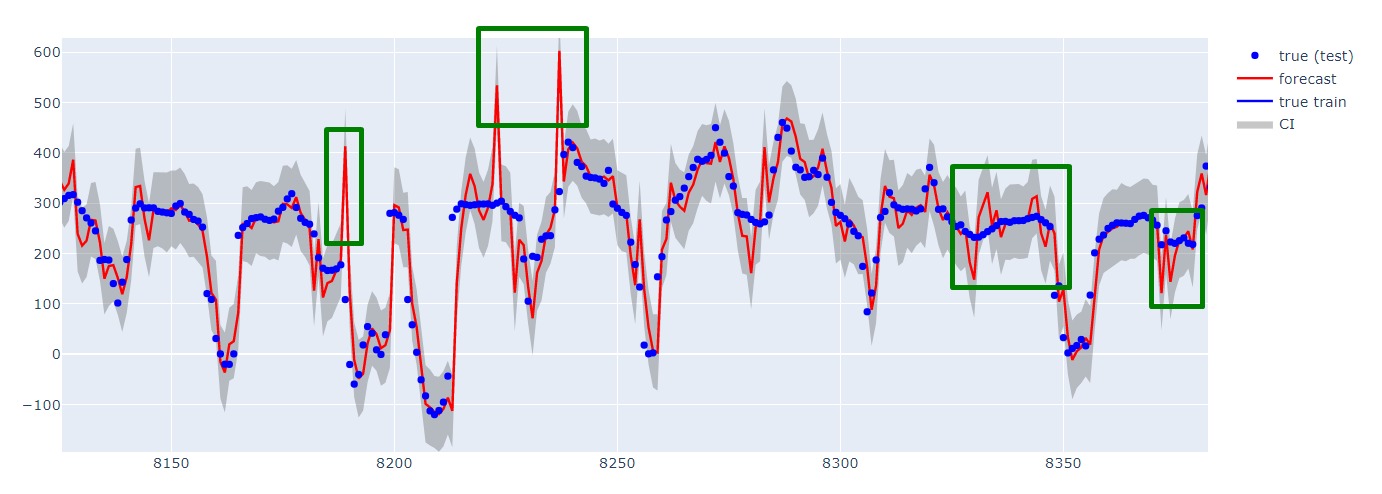

Let's define a function that plots some overview of the models performancce

In [ ]:
def plot_dow_hod(df_test, y_test):
    df = df_test.copy()
    df["pred"] = np.array(y_test)

    df = add_calendar_features(df)
    
    df_test_dow = df.groupby(["Day of Week"]).mean().reset_index()
    df_test_hod = df.groupby(["Hour"]).mean().reset_index()

    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    fig = make_subplots(rows=1, cols=2, subplot_titles=["Hour of Day", "Day of Week", "Overall"])

    fig.update_layout(
        barmode='group',
        title_text="Predicted vs actual values by hour of day and day of week"
    )
    
    hods = ["0"+str(i)+":00" if i < 10 else str(i)+":00" for i in range(0,24)]
    dows = [calendar.day_abbr[i] for i in df_test_dow["Day of Week"]]

    
    fig.append_trace(go.Bar(name='Predicted', x=months, y=df_test_hod["pred"], marker_color="red"), row=1, col=1)
    fig.append_trace(go.Bar(name='Predicted', x=dows, y=df_test_dow["pred"], showlegend=False, marker_color="red"), row=1, col=2)
        
    fig.append_trace(go.Bar(name='Actual', x=months, y=df_test_hod["SpotPriceDKK"], marker_color="blue"), row=1, col=1)
    fig.append_trace(go.Bar(name='Actual', x=dows, y=df_test_dow["SpotPriceDKK"], showlegend=False, marker_color="blue"), row=1, col=2)
    
    fig.update_yaxes(title_text="Average electricity price DKK/MWh", row=1, col=1)
    
    fig.show()

In [ ]:
# Note that we ran the AR(2) cells again such that the y_pred variable holds the predictions from the AR(2) model and not the last model.
plot_dow_hod(ts_results[["SpotPriceDKK"]]["2019-10-01":], y_pred) 

Of course the averaging of the values is expected to yield even better results, since the error of the model is mostly in the increased volatility, which would not affect the average of the predicted values.

### Additional features
The confidence intervals of the models were quite wide indicating uncertainty in the prediction. As the electricity price by no means is an easy entity to predict this is not unexpected, however, as data scientists we always strive for better models. One extension to the model could be to include additional features such as the price of other energy sources such as oil and gas. The marginal cost of generating electricity is heavily influenced by these and thus should be correlated with the electricity price. The same reasoning can be applied to all quantifiable metrics that are related to either the supply or demand of energy. This is definitely an area worth investigating in future work! 

### More data
The time horizon of the data was chosen to be the year of 2019. This was mainly to ensure that the distribution of the electricity price was similar throughout the period. If we had included 2020, the data would have been greatly impacted by the Covid-19 crisis, which drastically changed the patterns of the electricity price. However, what is the model worth if it cannot be used in unprecedented time periods? Following this chain of thought and the reflections in the above section, it is evident that for a multi-year forecast model it is necessary to construct a model that allows the patterns and behavior of the electricity price to change. The fact that the final model is a temporal model should to some extent be able to account for this. However, again it would be interesting to see the performance of the model if the time period was an entire decade. Perhaps a dynamic variance throughout the years would be necessary?

### Multivariate LDS with external inputs
The fact that the electricity grid of Northern Europe is connected means that the electricity price is correlated. To widen the area of the research it could have been interesting to look at several geographical areas and construct at multivariate model. In this case, the electricity price of the geographical areas would be sampled from a multivariate normal distribution with a covariance accounting for the correlation between the prices. If the electricity price was missing at one area, the information from the other areas would allow for imputation. 

### Value of the results
The performance of the best model has an RMSE of 35.82 and a R2 score of 0.823. This is generally speaking a very high prediction level considering the nature of the data. However, as the models only predicts one hour ahead, the value of the model may be limited. In fact, an estimated electricity price is determined 24 hours ahead on the NordPool exchange based on bids from the electricity suppliers. Our prediction of the electricity price is thus only valuable for the intra-day price setting and not the day-ahead market, which is a significant limitation when considering real-life application. However, looking at the bigger picture it is indeed very valuable to be able to predict the future in energy domain and other domains such as the transport domain.